#**Introduction to Time series**

A **time series** is a sequence of data points recorded or measured at successive points in time, usually at uniform intervals. Time series analysis involves methods for analyzing these data points to extract meaningful statistics and identify characteristics of the data.

**Components of Time Series**
1. **Trend Component (T)**: Represents the general direction or pattern of the data over a long period.
2. **Seasonal Component (S)**: Captures the periodic fluctuations within a specific period (e.g., quarterly sales).
3. **Cyclic Component (C)**: Refers to long-term oscillations that are not necessarily periodic.
4. **Irregular Component (I)**: Random or residual variations after accounting for trend, seasonality, and cyclic components.

**Decomposition of Time Series**  
Time series can be decomposed into its components using either additive or multiplicative models:

* **Additive Model:**
Y(t)=T(t)+S(t)+C(t)+I(t)

 Data has same width and height of the seasonal patterns or peaks. Trend of the data is linear.

* **Multiplicative Model:**
Y(t)=T(t)×S(t)×C(t)×I(t)

 Data has increasing / decreasing width and height of the seasonal patterns or peaks. Trend of the data is non-linear.

# **Title: Forecasting Air Passenger Numbers Based on Time Series Data**

### **Objective:**
The primary objective of this project is to forecast the number of air passengers for future months based on historical time series data. This will help airlines, travel agencies, and related stakeholders make informed decisions about capacity planning, resource allocation, and operational efficiency.

###**Description:**
We have a time series dataset with monthly records of the number of passengers traveling by air. The dataset includes:

- Month: A timestamp representing the month and year.
- Passengers: The number of passengers for that month.

The goal is to use historical data to build a predictive model that can accurately forecast future passenger numbers. This involves time series analysis and forecasting techniques to identify patterns, trends, and seasonal effects.

### **Notebook Contents :**
- Dataset Information
- Time Series Analysis
- Modeling
- Conclusion

### **What we will learn :**
- Statistical Tests for Time Series Analysis.
- Order selection for ARIMA & SARIMA models.
- In-sample and Out-of-sample forecasting using rolling & non-rolling methods.
- Difference between forecast function and predict function of ARIMA & SARIMA

# **Importing Libraries and Loading Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("/content/AirPassengers.csv")
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


# Data Info

In [7]:
print(data.shape,"\n")
print(data.columns,"\n")

(144, 2) 

Index(['Month', '#Passengers'], dtype='object') 



In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [9]:
data.isnull().sum()

,0
Month,0
#Passengers,0


- **No null values** present in the data , so we can procede further

In [10]:
data.describe()

,#Passengers
count,144.00
mean,280.30
std,119.97
min,104.00
25%,180.00
50%,265.50
75%,360.50
max,622.00


#### **Interpretation:**
The data shows a typical monthly passenger count with a mean of around 280, but there is significant variability (standard deviation of 120). The number of passengers ranges from a minimum of 104 to a maximum of 622, with a median value of 266, indicating that while most months have a moderate number of passengers, there are occasional peaks. The 25th percentile and 75th percentile values suggest that the number of passengers can vary considerably, reflecting both lower and higher passenger months.

# **Preprocessing the Data(Date Parsing and Indexing)**

In [12]:
data['Date'] = pd.to_datetime(data['Month'])
data = data.drop(columns = 'Month')
data = data.set_index('Date')
data = data.rename(columns = {'#Passengers':'Passengers'})
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- Converting the datatype of the **Month** column to datetime datatype and setting it as the index of the dataset.
- Renaming the column **Month** to **Date** and **#Passengers** to **Passengers** as well.
- It is a monthly distributed data.

# <center>**Time Series Analysis**</center>

### Supportive Functions for Time Series Analysis :


**FOR STATIONARY DATA CHECKING:**
- **ROLLING STATISTICS**
- **DF**



**1. Rolling Statistics (Visual Check):**

**What it does:** It helps you visually inspect the time series by plotting the rolling mean and rolling standard deviation over time.

**Why it’s useful:**
It provides a quick visual assessment of whether the mean and variance of the time series remain constant over time.

A stationary series will have nearly constant rolling mean and standard deviation, showing little to no trend or seasonal effects.

**Limitations:** It’s a subjective method since it relies on visual interpretation, which can be misleading if the changes are subtle.

**2. Dickey-Fuller Test (Statistical Test):**

**What it does:** It is a statistical hypothesis test specifically designed to check for stationarity.

**Why it’s useful:**
It provides an objective and quantitative result (test statistic and p-value) to determine whether the time series is stationary.
It considers both trend and noise when determining stationarity.

**Limitations:** The Dickey-Fuller test might indicate non-stationarity even if the series visually appears stationary (e.g., due to slight trends).

The **Dickey-Fuller test is a hypothesis test** where:
- **Null Hypothesis (H₀):** The time series is non-stationary.
- **Alternative Hypothesis (H₁):** The time series is stationary.

In [11]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()        # MA = means MSTD = standard deviation and window = 12 because our data is according to month
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Comprehensive visual and statistical analysis of a time series:
- Quickly visualize the data.
- Check for stationarity using the ADF test.
- Analyze autocorrelation patterns through ACF and PACF plots.

In [13]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)           # time series plot
        acf_ax = plt.subplot2grid(layout, (1, 0))                     # ACF
        pacf_ax = plt.subplot2grid(layout, (1, 1))                    # PACF

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]                      # ADF
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

### **Components of Time Series :**
- A Time Series consists of the following components :

    - **Trend** : Long term direction of the data.
    
    E.g : Year on year rising temperature of the Earth due to Global Warming.
    
    - **Seasonality** : Short term repetitve patterns of the data due to the weather seasons.
    
    E.g : Sale of sweaters specifically in the winter season.
    
    - **Cyclic Variations** : Short term repetitive patterns of the data over a period of 1 year.
    
    E.g : It usually consists of the Business Quarters i.e Q1, Q2, Q3 & Q4.
    
    - **Irregularities** : Random and unforseen fluctuations in the data.
    
    E.g : Occurrences of Earthquakes or Floods, etc.
    
    
- **In order to assess a Time Series, we need to consider the above components and make sure that our data is free from all these components in order to make a forecast.**

Let's visualize the **Passengers** data for the above components!
- For this purpose, we use a function **seasonal_decompose** from the **statsmodel** library.
- This function has a parameter, **model**, that needs to be assigned the value **additive** or **multiplicative**.
    - **Additive Model** : Data has same width and height of the seasonal patterns or peaks. Trend of the data is linear.
    - **Multiplicative Model** : Data has increasing / decreasing width and height of the seasonal patterns or peaks. Trend of the data is non-linear.

<Axes: xlabel='Date'>

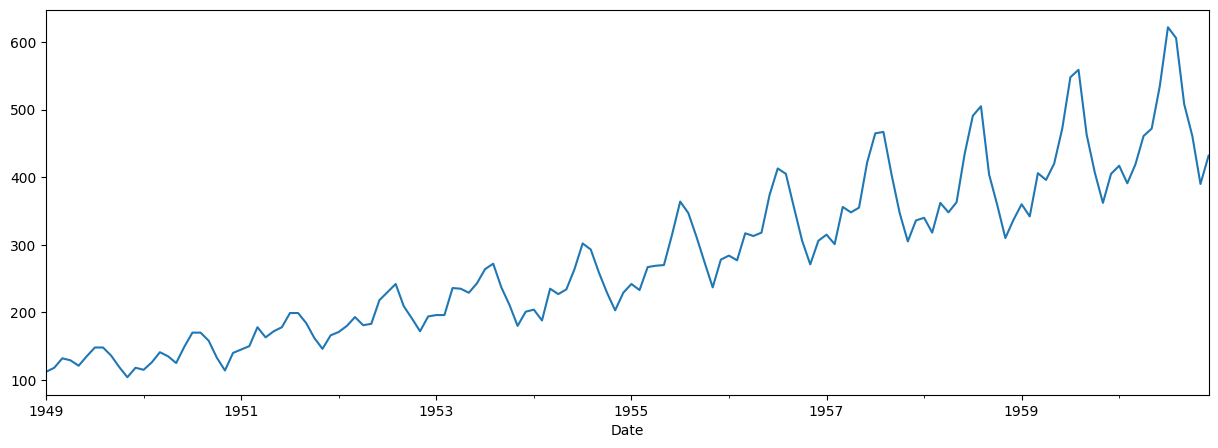

In [14]:
plt.figure(figsize = (15,5))
data['Passengers'].plot()

- From the above graph of **Passengers** data, we can say that it represents a **Multiplicative Model** as the data has increasing width & height of the peaks.
- Let us decompose the multiple components of the **Passengers** time series.

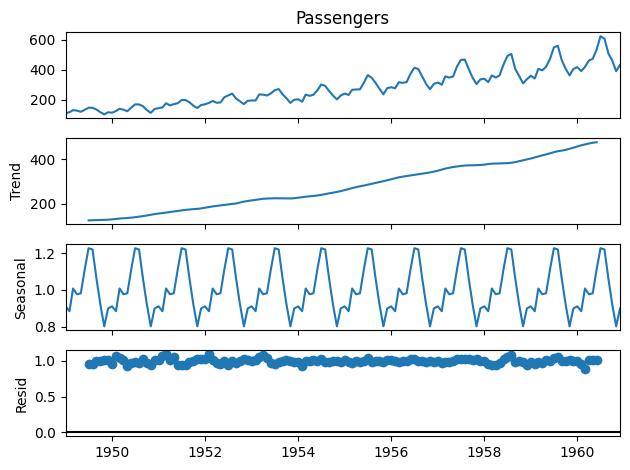

In [15]:
dec = sm.tsa.seasonal_decompose(data['Passengers'],period = 12, model = 'multiplicative').plot()
plt.show()

- Data clearly has a **linear uptrend**.
- A clear cut **seasonal** pattern of a 1 year duration is present in the data.
- We also need to check the statistical parameters w.r.t time.

-> The dataset shows a **linear uptrend**, meaning the number of passengers is steadily increasing over time. This suggests that over the years, there has been a consistent growth in air travel, which could be due to factors like economic growth, increased accessibility, or population growth.

-> The data shows a **seasonal pattern** that repeats every year. This is typical for air passenger data, where certain months (like summer or holiday seasons) see higher travel volumes than others.



### Stationarity :

- **Stationarity** is a concept for time series where statistical parameters like mean, variance, etc are all constant over time.
- For a time series, features are dependent on time i.e **features are a function of time**. Statistical paramters will change values over time as they are extracted from the features.
- If the time series is not stationary, then the predictions deviate from the original values and increase the error as we don't know the changes in these statistical parameters as they are a function of time.
- Thus, by making time series stationary, we kind of nullify the effects of statistical parameters on the forecast.
- To test stationarity, we will use **Augmented Dickey Fuller Test** :
    - **Null Hypothesis** : It assumes that the time series is non-stationary.
    - **Alternate Hypothesis** : If the null hypothesis is rejected, then the time series is stationary.
    - Output of the **Augmented Dickey Fuller Test** include :
        - **Test Statistic**
        - **p-value**
        - **#Lags Used**
        - **Number of Observations Used**
        - **Critical Value (1%)**
        - **Critical Value (5%)**
        - **Critical Value (10%)**
- For the **Null Hypothesis** to be rejected and accepting that the time series is stationary, there are 2 requirements :
    - **Critical Value (5%)** > **Test Statistic**
    - **p-value** < 0.05

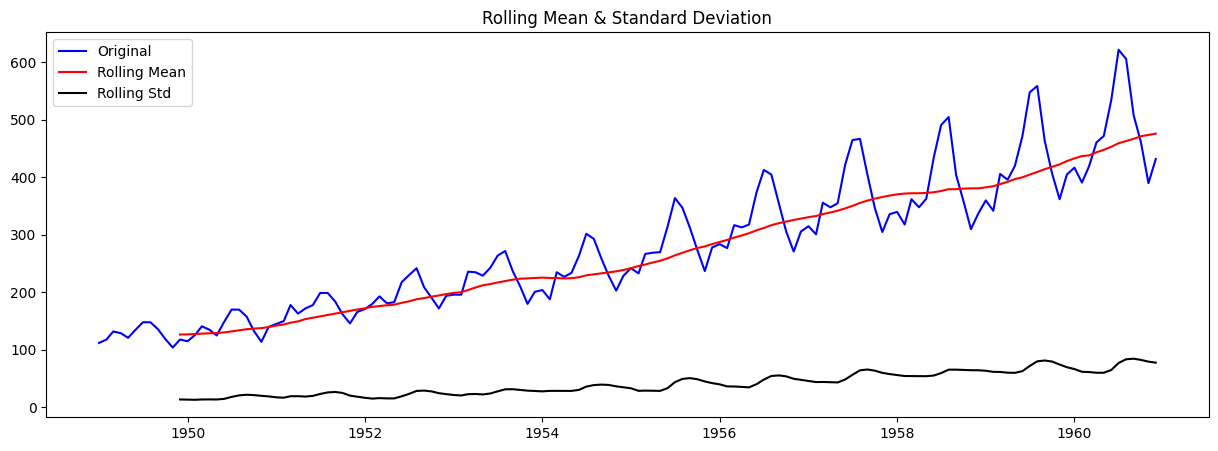

Results of Dickey-Fuller Test:
Test Statistic                  0.82
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [16]:
test_stationarity(data['Passengers'])

- For the **Passengers** time series data,
    - **Rolling Mean** is clearly variable with time.
    - **Rolling Standard Deviation** is has some crests - troughs that vary according to the time.
    - **Test Statistic : (0.82)** > **Critical Value (5%) : (-2.88)**
    - **p-value (0.99)** > 0.05
- Hence, **Null Hypothesis** cannot be rejected and we can conclude that the above **Passengers** time series is **not stationary**.
- In order to eliminate trend, seasonality and make the time series stationary, we will use **differencing** i.e subtracting the previous value from it's next value. We will work on log values of the data from here!

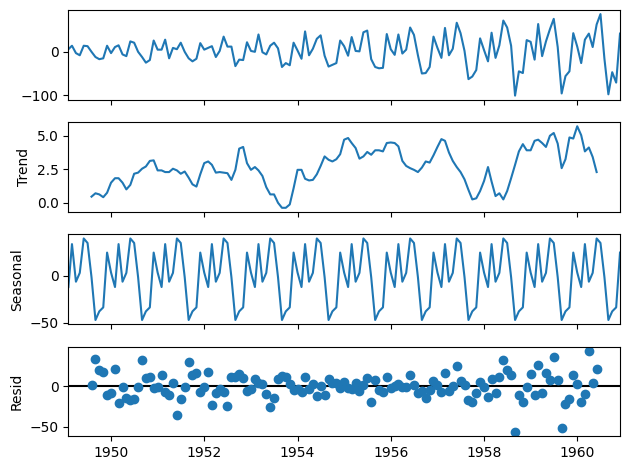

In [17]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

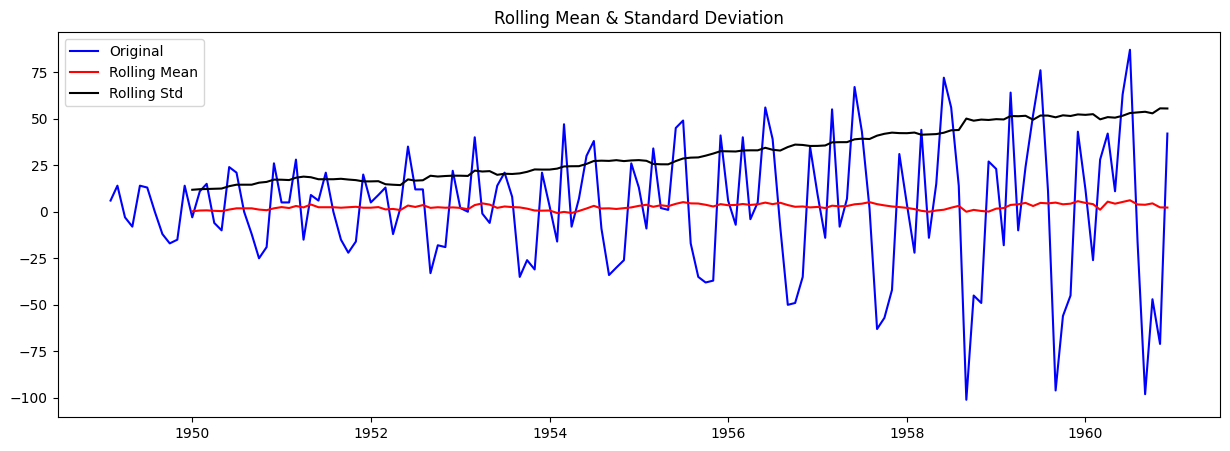

Results of Dickey-Fuller Test:
Test Statistic                 -2.83
p-value                         0.05
#Lags Used                     12.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [18]:
test_stationarity(data_diff)

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0.
    - **Rolling Standard Deviation** displays a slight uptrend over time.
    - **Test Statistic : (-2.83)** > **Critical Value (5%) : (-2.88)**.
    - **p-value (0.05)** > **0.05**
- From the above values, we will use the above time series despite it just fails on the **stationarity** test.
- Effect of **double-differencing** would be too heavy on the data and might result in poor performance.

# **!!!!!!!!!!!!!!!!!**

- We have taken the **log** of the data to deal with **stationarity** and **differencing** is done to handle **trend** and **seasonality**.
- **Trend** of the data has near about died down & their values have been reduced as well. However, **Seasonality** of the data is clearly visible.
- We now check the **stationarity** of the time series.

In [19]:
# Log transformation of the series
data['Log_Passengers'] = np.log(data['Passengers'])

# Differencing to remove trend
data_diff = data['Log_Passengers'].diff().dropna()

# Seasonal differencing to remove seasonality
data_diff_seasonal = data_diff.diff(12).dropna()

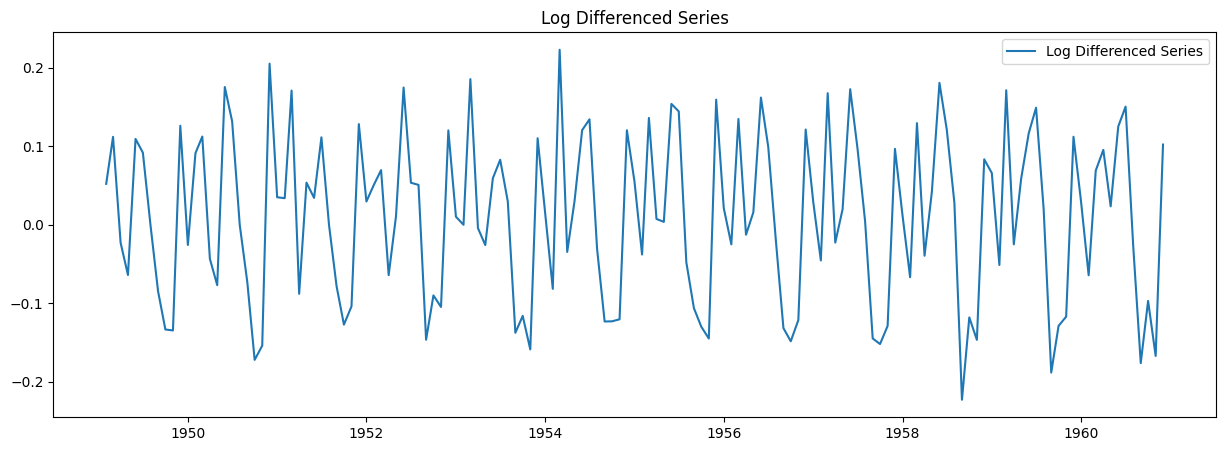

Testing stationarity of the log-differenced series:


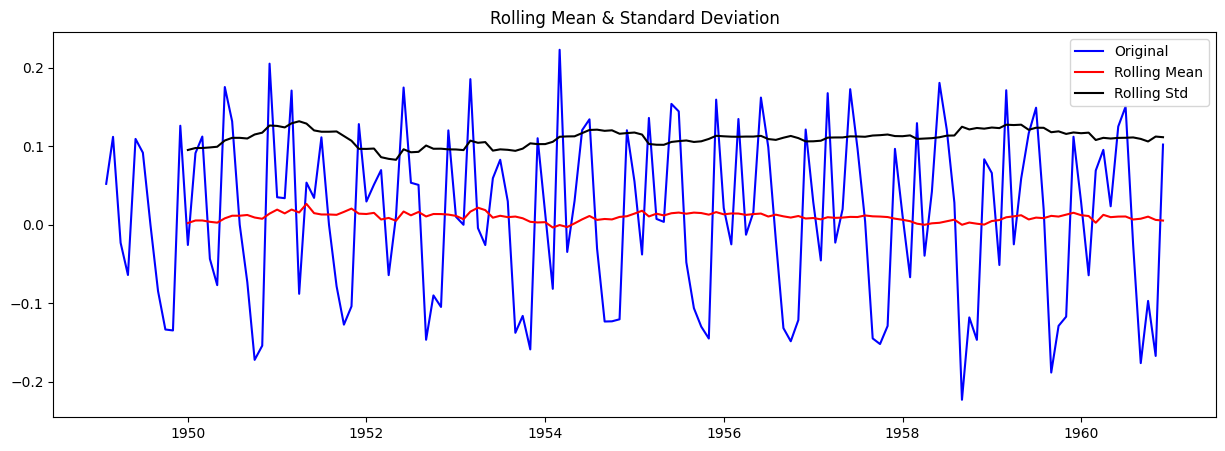

Results of Dickey-Fuller Test:
Test Statistic                 -2.72
p-value                         0.07
#Lags Used                     14.00
Number of Observations Used   128.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


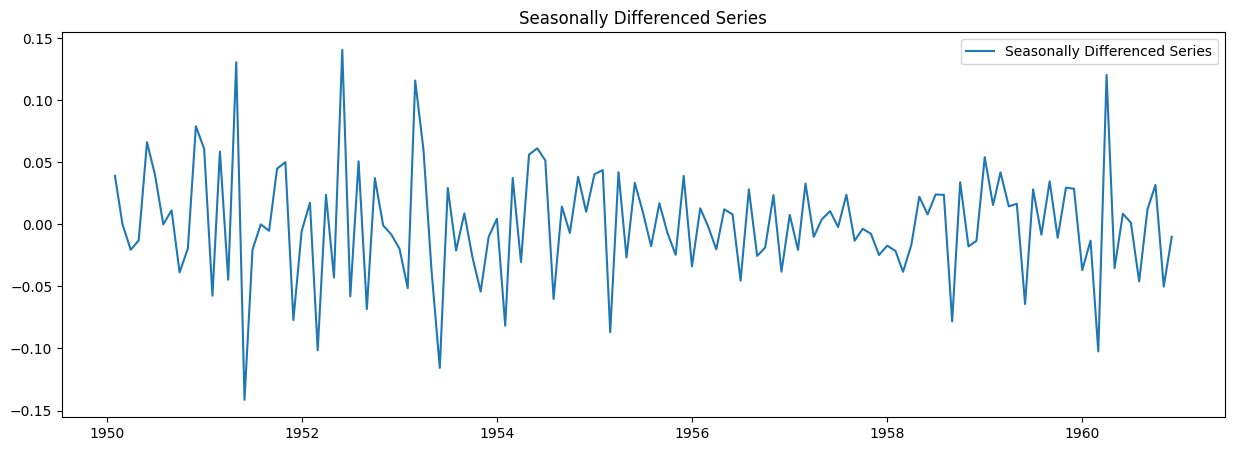

Testing stationarity of the seasonally differenced series:


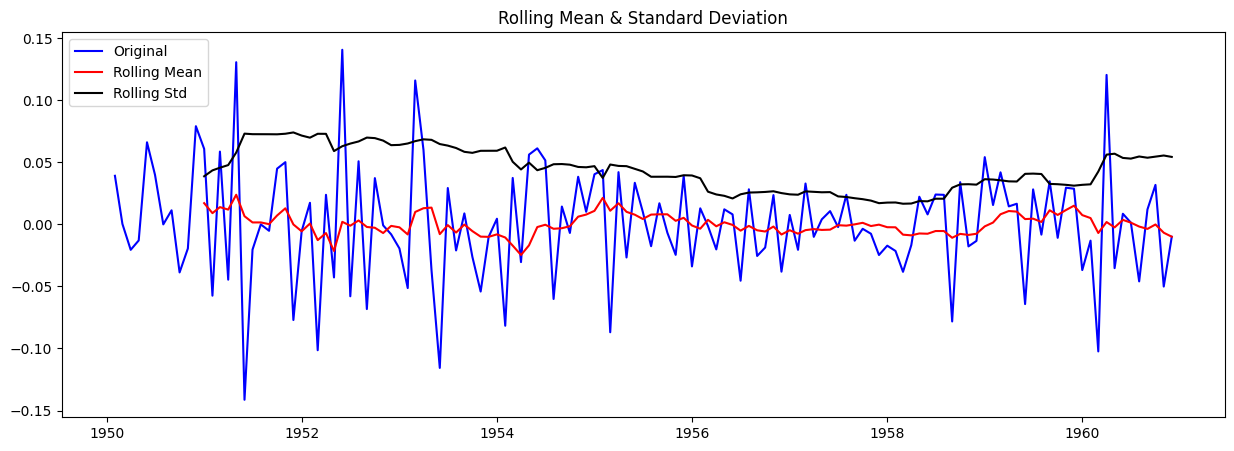

Results of Dickey-Fuller Test:
Test Statistic                 -4.44
p-value                         0.00
#Lags Used                     12.00
Number of Observations Used   118.00
Critical Value (1%)            -3.49
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58
dtype: float64


In [ ]:
# Plotting the log-differenced series
plt.figure(figsize=(15, 5))
plt.plot(data_diff, label='Log Differenced Series')
plt.legend(loc='best')
plt.title('Log Differenced Series')
plt.show()

# Testing stationarity of the log-differenced series
print("Testing stationarity of the log-differenced series:")
test_stationarity(data_diff)

# Plotting the seasonally differenced series
plt.figure(figsize=(15, 5))
plt.plot(data_diff_seasonal, label='Seasonally Differenced Series')
plt.legend(loc='best')
plt.title('Seasonally Differenced Series')
plt.show()

# Testing stationarity of the seasonally differenced series
print("Testing stationarity of the seasonally differenced series:")
test_stationarity(data_diff_seasonal)

Given that the test statistic is much lower than the critical values and the p-value is very small, you can reject the null hypothesis of the Dickey-Fuller test. This means that your time series is likely stationary, which is a good sign for applying ARIMA models.

**The time series, after undergoing log transformation, differencing, and seasonal differencing, has successfully achieved stationarity, as confirmed by the Dickey-Fuller test. With a significant test statistic and a p-value near zero, the series is now ready for accurate modeling using ARIMA or SARIMA techniques.**

# **Modeling**

# **ARIMA MODEL**

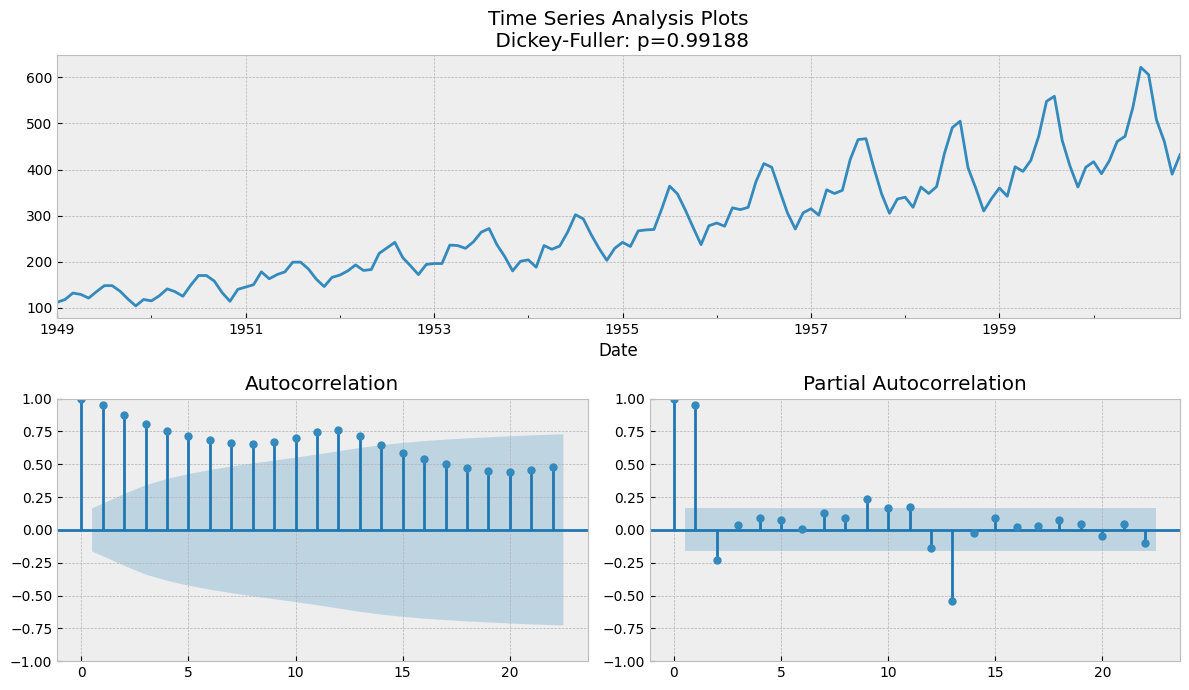

In [20]:
tsplot(data['Passengers'])

- **ACF** graph provides the correlation between the time series & it's lags. For the above time series, we can observe a positive lowering correlation.
- **PACF** graph provides the correlation between the time series and individual lags. These correlation coefficients are unlike the mutual correlations that are calculated in the presence of other features.
- From the **PACF** graph above, the 1st lag is out of the confidence interval and probably the most significant lag. It probably dictates the pattern for the **ACF** graph where the next lag follows it's previous lag.

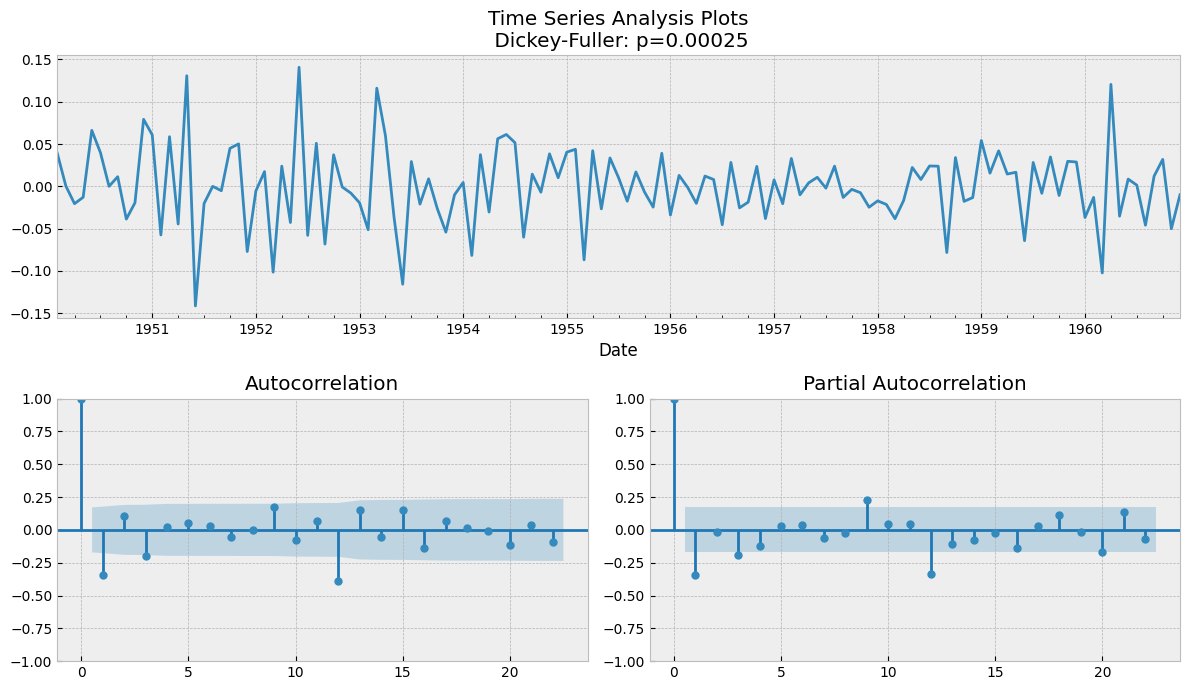

In [21]:
tsplot(data_diff_seasonal)

In [22]:
# Fit the ARIMA model
model = ARIMA(data['Log_Passengers'], order=(2, 1, 2))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         Log_Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 128.890
Date:                Wed, 28 Aug 2024   AIC                           -247.780
Time:                        06:32:50   BIC                           -232.965
Sample:                    01-01-1949   HQIC                          -241.760
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2432      0.166      1.469      0.142      -0.081       0.568
ar.L2          0.2677      0.199      1.344      0.179      -0.123       0.658
ma.L1         -0.0867      0.118     -0.732      0.4

**Splitting Dataset**

In [23]:
# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data['Log_Passengers'].iloc[:train_size], data['Log_Passengers'].iloc[train_size:]

In [24]:
# Fit the ARIMA model
model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         Log_Passengers   No. Observations:                  115
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 104.653
Date:                Wed, 28 Aug 2024   AIC                           -199.305
Time:                        06:34:06   BIC                           -185.624
Sample:                    01-01-1949   HQIC                          -193.753
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2467      0.187      1.316      0.188      -0.121       0.614
ar.L2          0.2590      0.241      1.074      0.283      -0.214       0.732
ma.L1         -0.0878      0.141     -0.622      0.5

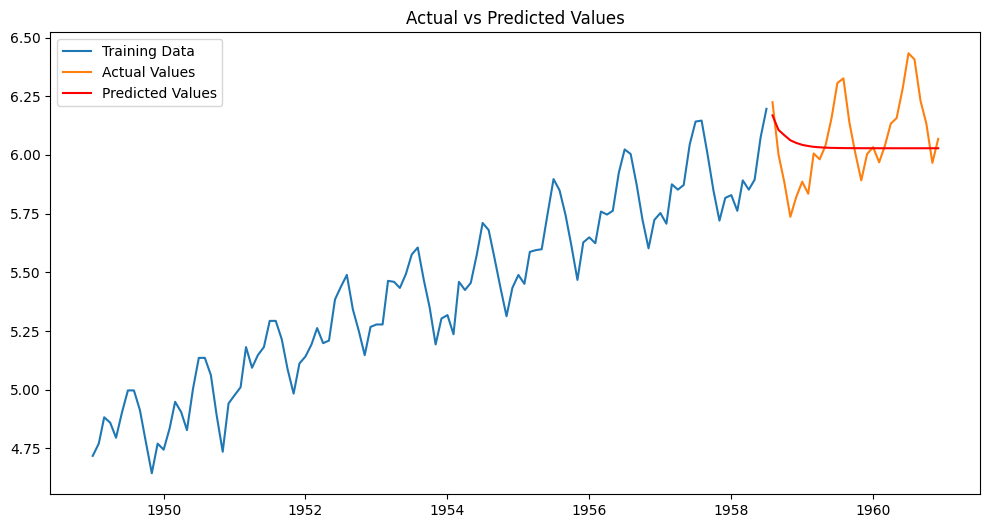

In [ ]:
# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Convert predictions to a Series with the same index as test
predictions = pd.Series(predictions, index=test.index)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Values')
plt.plot(predictions, label='Predicted Values', color='red')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

**Conclusion:**

The model needs improvement, possibly by better tuning of parameters or incorporating a more suitable model to handle the seasonality and other complexities of the data.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-213.916, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189.733, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-191.035, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-192.641, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.957, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-216.555, Time=0.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-214.724, Time=0.47 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-218.097, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-200.633, Time=0.32 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-219.339, Time=0.75 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-198.633, Time=2.59 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-214.474, Time=2.24 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=i

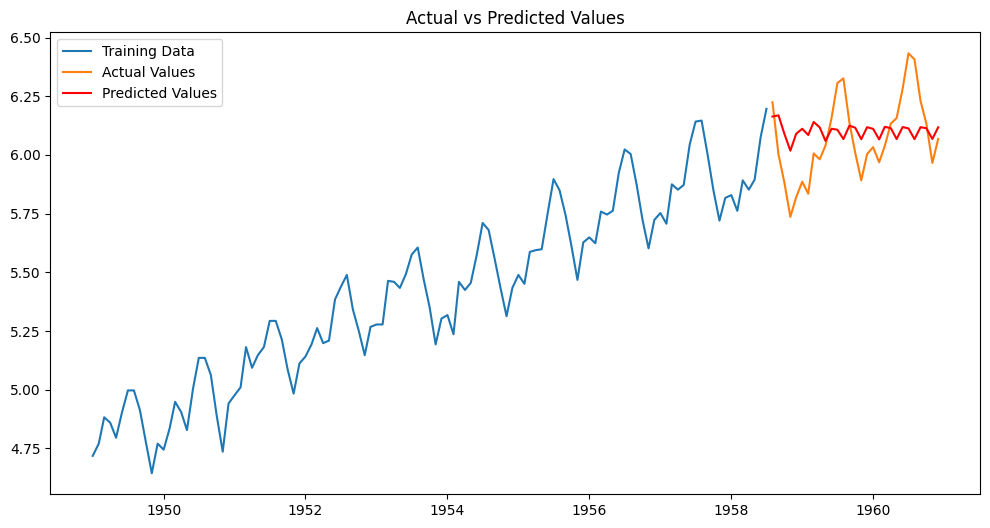

In [30]:
from pmdarima import auto_arima


# Find the best ARIMA parameters using auto_arima
auto_model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, trace=True)

# Print the summary of the best model found
print(auto_model.summary())

# Fit the model with the determined parameters
best_order = auto_model.order
model = ARIMA(train, order=best_order)
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))
predictions = pd.Series(predictions, index=test.index)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Values')
plt.plot(predictions, label='Predicted Values', color='red')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

In [29]:
#pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.6 MB/s eta 0:00:00


In [31]:
# Calculate MAPE
mape = mean_absolute_percentage_error(test, predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Percentage Error (MAPE): 2.35%
Root Mean Squared Error (RMSE): 0.17


**SARIMA(p,d,q)*(P,D,Q,S)**

In [32]:
# Fit the SARIMA model
model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                       Log_Passengers   No. Observations:                  115
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 190.437
Date:                              Wed, 28 Aug 2024   AIC                           -366.875
Time:                                      06:46:24   BIC                           -348.500
Sample:                                  01-01-1949   HQIC                          -359.434
                                       - 07-01-1958                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0171      0.661     -0.026      0.979      -1.314       1.279
ar.L2          0.42

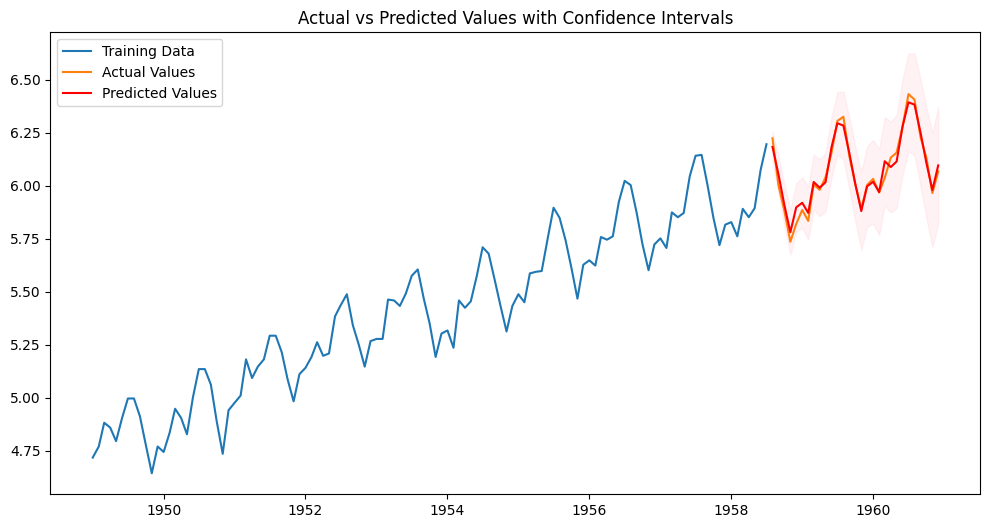

In [ ]:
# Make predictions
predictions = model_fit.get_forecast(steps=len(test))
predicted_mean = predictions.predicted_mean
conf_int = predictions.conf_int()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Values')
plt.plot(predicted_mean, label='Predicted Values', color='red')
plt.fill_between(predicted_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.legend()
plt.title('Actual vs Predicted Values with Confidence Intervals')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-371.453, Time=3.50 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-271.901, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-366.335, Time=0.89 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-335.954, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-108.879, Time=0.05 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-375.725, Time=1.58 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-348.802, Time=0.87 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-373.726, Time=4.57 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-367.460, Time=4.59 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-371.829, Time=4.83 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-376.939, Time=1.74 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-348.813, Time=0.68 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-372.099, Time=1.66 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-374.916, Time=6.21 sec
 ARIMA(1,0,2)(1,1,0

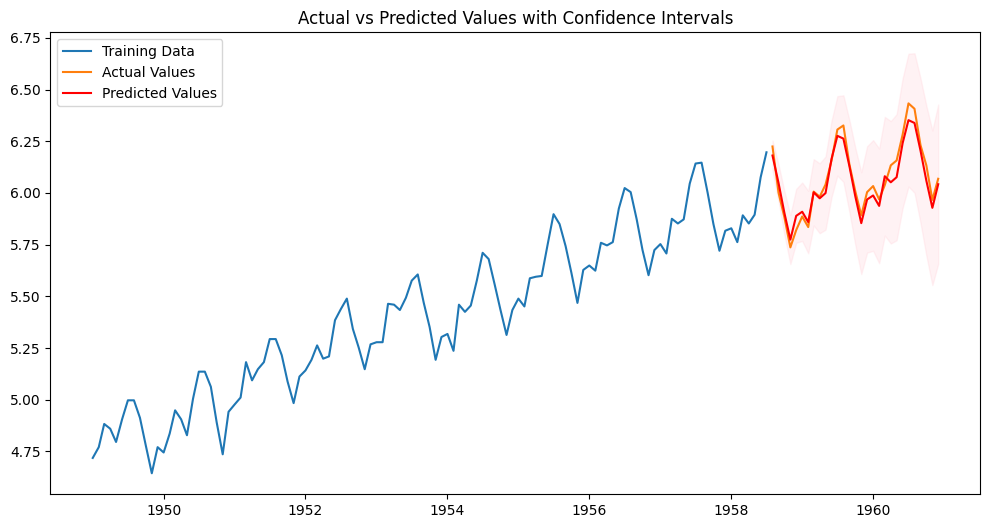

In [ ]:
# Find the best SARIMA parameters using auto_arima
auto_model = auto_arima(train, seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)  # Adjust 'm' as needed

# Print the summary of the best model found
print(auto_model.summary())

# Fit the SARIMA model with the determined parameters
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
model_fit = model.fit()

# Make predictions
predictions = model_fit.get_forecast(steps=len(test))
predicted_mean = predictions.predicted_mean
conf_int = predictions.conf_int()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Values')
plt.plot(predicted_mean, label='Predicted Values', color='red')
plt.fill_between(predicted_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.legend()
plt.title('Actual vs Predicted Values with Confidence Intervals')
plt.show()

In [ ]:
y_true = test.values
y_pred = predicted_mean.values

# Calculate MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print the metrics
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Percentage Error (MAPE): 0.66%
Root Mean Squared Error (RMSE): 0.05


# **Conclusion**

In this project, we performed time series forecasting for air passenger data using both ARIMA and SARIMA models. After thoroughly preprocessing the data to address stationarity and seasonality, we applied ARIMA and SARIMA models to predict future passenger numbers. The ARIMA model, optimized with the auto_arima function, achieved a Mean Absolute Percentage Error (MAPE) of 2.35% and a Root Mean Squared Error (RMSE) of 0.17. The SARIMA model, also optimized using auto_arima, demonstrated improved accuracy with a MAPE of 0.66% and an RMSE of 0.05. These results indicate that the SARIMA model provided a more precise forecast, successfully capturing both the trend and seasonality of the data.

The forecasting accuracy achieved with the SARIMA model underscores its effectiveness in handling seasonal patterns, making it a robust choice for time series data with such characteristics. The ARIMA model, while slightly less accurate, still offered valuable insights and served as a useful comparison.

## **Future Plans**
- Model Enhancement: Explore additional variations of time series models, such as Exponential Smoothing State Space Models (ETS) or more advanced machine learning techniques like LSTM networks, to further improve forecasting accuracy.

- Hyperparameter Tuning: Conduct more extensive hyperparameter tuning and cross-validation to refine the models and ensure optimal performance across different datasets.

- Incorporate Exogenous Variables: Investigate the inclusion of external factors (e.g., economic indicators, promotional events) that may influence passenger numbers to enhance the model's predictive power.

- Real-time Forecasting: Develop a real-time forecasting system to continuously update predictions and adapt to new data, providing actionable insights for decision-making.

- Visualization and Communication: Enhance visualization tools to better communicate forecast results and uncertainties to stakeholders, supporting more informed decision-making processes.

By implementing these future plans, we aim to further refine our forecasting approach and provide even more accurate and actionable insights into air passenger trends.